In [54]:
import transformers
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [55]:
torch.manual_seed(1)
device = torch.device('cpu')

In [56]:
model_name = "KB/bert-base-swedish-cased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at KB/bert-base-swedi

In [57]:
class QuestionDataset(torch.utils.data.Dataset):
    def __init__(self, questions, labels, tokenizer):
        self.questions = questions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = str(self.questions[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            question,
            add_special_tokens=True,
            max_length=64,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        ).to(device)

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": label,
        }

In [58]:
data = pd.read_csv('dataset.csv')

# Divide the data into training, validation and test
training_data, testing_data = train_test_split(data, test_size=0.2, random_state = 1)
training_data, validation_data = train_test_split(training_data, test_size = 0.25, random_state = 1)

print("training data: ", training_data.shape)
print("validation data: ", validation_data.shape)
print("testing data: ", testing_data.shape)

training data:  (4800, 2)
validation data:  (1600, 2)
testing data:  (1600, 2)


In [59]:
# Load datasets into QuestionDataset objects
training_dataset = QuestionDataset(questions=training_data["question"].tolist(), labels=training_data["label"].tolist(), tokenizer=tokenizer)
validation_dataset = QuestionDataset(questions=validation_data["question"].tolist(), labels=validation_data["label"].tolist(), tokenizer=tokenizer)
testing_dataset = QuestionDataset(questions=testing_data["question"].tolist(), labels=testing_data["label"].tolist(), tokenizer=tokenizer)

In [60]:
def collate_fn(samples):
    input_ids = []
    attention_masks = []
    labels = []

    for sample in samples:
        input_ids.append(sample['input_ids'])
        attention_masks.append(sample['attention_mask'])
        labels.append(sample['label'])

    # Padding
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True)
    attention_masks = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [61]:
# Load the pre-trained model
model_name = "KB/bert-base-swedish-cased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

# Set up the optimizer and the loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Load your dataset into a DataLoader
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Fine-tune the model on your dataset
num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    batch_count = 0
    epoch_train_loss = 0
    for batch in train_loader:
        # Show progress in percentage
        batch_count += 1
        print(f"\r{batch_count/len(train_loader)*100:.2f}%", end="")

        # Load the batch into the device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask = attention_mask)
        logits = outputs.logits

        # Compute the loss
        loss = loss_fn(logits, labels)
        epoch_train_loss += loss.item()  # Accumulate the loss

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Evaluate the model on the validation set
    val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 16, collate_fn = collate_fn)
    model.eval()
    epoch_val_loss = 0
    val_preds = []
    val_labels = []
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask = attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)  # Compute the validation loss
        epoch_val_loss += loss.item()  # Accumulate the loss
        preds = torch.argmax(logits, axis=1)
        val_preds.extend(preds.tolist())
        val_labels.extend(labels.tolist())
        
    val_losses.append(epoch_val_loss / len(val_loader))

    val_acc = sklearn.metrics.accuracy_score(val_labels, val_preds)
    print()
    print(f"Validation accuracy: {val_acc:.4f}")
    epoch_save_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), epoch_save_path)

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at KB/bert-base-swedi

Epoch 1/10
100.00%
Validation accuracy: 0.9769
Epoch 2/10
100.00%
Validation accuracy: 0.9894
Epoch 3/10
100.00%
Validation accuracy: 0.9881
Epoch 4/10
100.00%
Validation accuracy: 0.9894
Epoch 5/10
100.00%
Validation accuracy: 0.9900
Epoch 6/10
100.00%
Validation accuracy: 0.9894
Epoch 7/10
100.00%
Validation accuracy: 0.9900
Epoch 8/10
100.00%
Validation accuracy: 0.9900
Epoch 9/10
100.00%
Validation accuracy: 0.9894
Epoch 10/10
100.00%
Validation accuracy: 0.9894


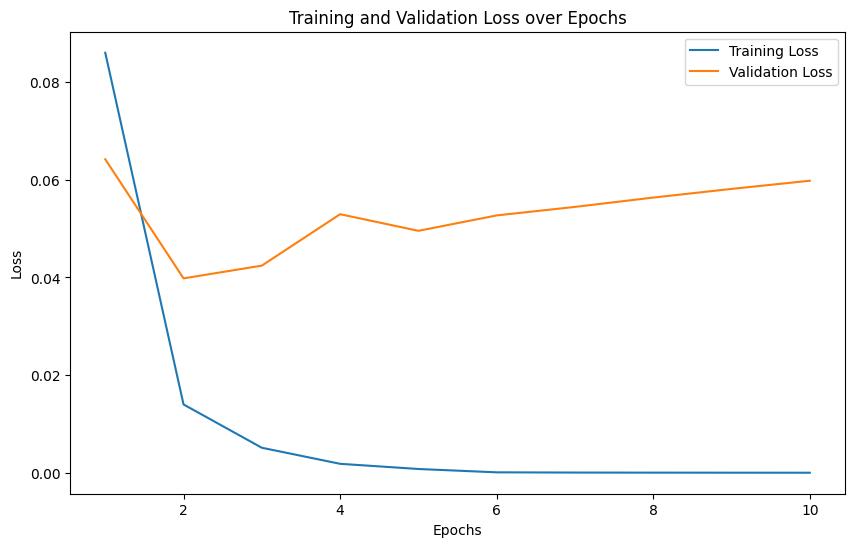

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_epochs) + 1, train_losses, label="Training Loss")
plt.plot(np.arange(num_epochs) + 1, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.show()

In [64]:
# Load the model from epoch 2
model_epoch_2 = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)
model_epoch_2.load_state_dict(torch.load(os.path.join(save_dir, "model_epoch_2.pt")))

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at KB/bert-base-swedi

<All keys matched successfully>

In [65]:
# Evaluate the model on the test set
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size = 16, collate_fn = collate_fn)
model_epoch_2.eval()
test_preds = []
test_labels = []
for batch in test_loader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model_epoch_2(input_ids, attention_mask = attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, axis=1)
    test_preds.extend(preds.tolist())
    test_labels.extend(labels.tolist())

test_acc = sklearn.metrics.accuracy_score(test_labels, test_preds)

              precision    recall  f1-score   support

           0    0.98353   0.99052   0.98701       844
           1    0.98933   0.98148   0.98539       756

    accuracy                        0.98625      1600
   macro avg    0.98643   0.98600   0.98620      1600
weighted avg    0.98627   0.98625   0.98625      1600



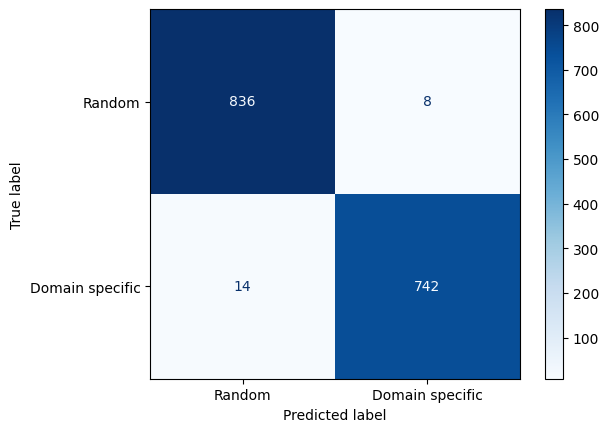

In [67]:
report = sklearn.metrics.classification_report(test_labels, test_preds, digits=5)
print(report)

# Create and display a graphical confusion matrix
cm = confusion_matrix(test_labels, test_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Random', 'Domain specific'])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()